In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn.model_selection
import time
#import antigravity
import random
random.seed()

In [2]:
data_train_path = 'data\\train.csv'
data_test_path = 'data\\test.csv'
src_data_train = pd.read_csv(data_train_path)
src_data_test = pd.read_csv(data_test_path)
src_data_test['SalePrice']=np.NaN # training target is denoted by NaN
source_data = pd.concat((src_data_train,src_data_test))
source_data=source_data.set_index('Id')
rows_test=np.where(np.isnan(source_data['SalePrice']))[0]
rows_train=np.where(~np.isnan(source_data['SalePrice']))[0]

p_target_basic = pd.DataFrame(source_data['SalePrice'])


In [3]:
p_data = pd.read_pickle('p_data.pickle')
p_data.shape

(2919, 62)

In [6]:
grid_depths=[2,3,4,5,6,7,8,9,10,11,12,13,14]
grid_eta=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.8,0.9,1.0]
grid_rounds=np.int32(np.logspace(np.log10(5.0),np.log10(150),15))
grid_internal_subsampling=[1.0]

validation_errors=[]
t_learning_costs=[]

t_etas=[]
t_depths=[]
t_rounds=[]
t_subsamplings=[]

best_depth=np.NaN;
best_rounds=np.NaN;
best_eta=np.NaN;
best_subsampling = np.NaN;

for local_subsampling in grid_internal_subsampling:
    for local_depth in grid_depths:
        for local_eta in grid_eta:        
            for local_rounds in grid_rounds:
                local_parameters = {
                    'max_depth':local_depth,
                    'eta':local_eta, 
                    'objective':'reg:squarederror',
                    'subsample':local_subsampling }
                random.seed(0)            
                rs = sklearn.model_selection.ShuffleSplit(n_splits=1, test_size=0.05, random_state=random.randint(1,1024))
                for train_index, validation_index in rs.split(rows_train):
                    xgb_train = xgb.DMatrix(p_data.iloc[train_index], label=p_target_basic.iloc[train_index])
                    xgb_validation = xgb.DMatrix(p_data.iloc[validation_index],label=p_target_basic.iloc[validation_index])
                    validation_target_values = p_target_basic.iloc[validation_index]['SalePrice']
                    t0=time.perf_counter_ns()
                    bst = xgb.train(local_parameters, xgb_train, local_rounds)    
                    validation_prediction = bst.predict(xgb_validation)
                    t_learning_cost=time.perf_counter_ns()-t0
                    validation_error=np.sqrt(np.mean(np.square(validation_target_values-validation_prediction)))    

                    validation_errors.append(validation_error)                
                    t_learning_costs.append(t_learning_cost)
                    t_etas.append(local_eta)
                    t_depths.append(local_depth)
                    t_rounds.append(local_rounds)
                    t_subsamplings.append(local_subsampling)

                    if validation_error==np.min(validation_errors):
                        best_depth=local_depth
                        best_rounds=local_rounds
                        best_eta=local_eta
                        best_subsampling = local_subsampling
                

min_error=np.min(validation_errors);
max_error=np.max(validation_errors);
mean_error=np.mean(validation_errors)
std_error=np.std(validation_errors)
print(f'best error: {min_error:0.2f} for depth={best_depth}, rounds={best_rounds}, eta={best_eta}, subsampling = {best_subsampling};  typical error: {mean_error:0.2f} ±{std_error:0.1f}')    
    
    

best error: 22677.25 for depth=8, rounds=27, eta=0.4, subsampling = 1.0;  typical error: 30599.87 ±5870.1


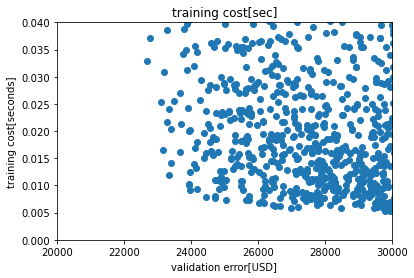

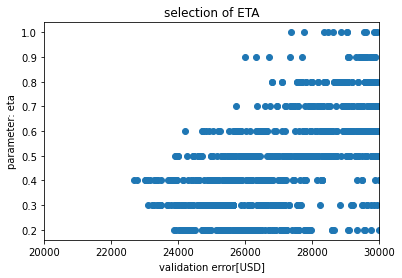

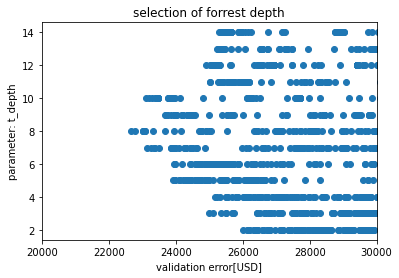

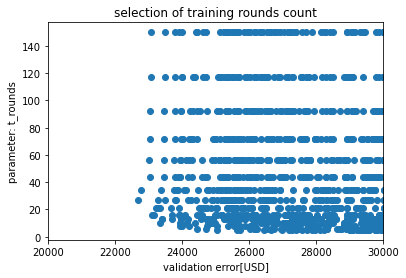

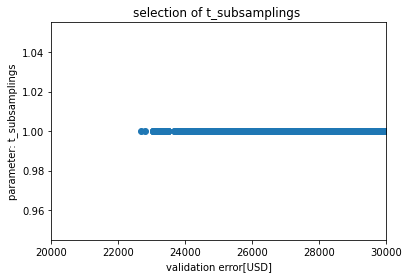

In [8]:
display_err_min=20000
display_err_max=30000
plt.scatter(validation_errors,np.array(t_learning_costs)*1e-9)
plt.xlabel('validation error[USD]')
plt.ylabel('training cost[seconds]')
plt.ylim(0,0.04)
plt.xlim(display_err_min,display_err_max)
plt.title('training cost[sec]')
plt.show()

plt.scatter(validation_errors,t_etas)
plt.xlabel('validation error[USD]')
plt.ylabel('parameter: eta')
plt.title('selection of ETA')
plt.xlim(display_err_min,display_err_max)
plt.show()

plt.scatter(validation_errors,t_depths)
plt.xlabel('validation error[USD]')
plt.ylabel('parameter: t_depth')
plt.title('selection of forrest depth')
plt.xlim(display_err_min,display_err_max)
plt.show()


plt.scatter(validation_errors,t_rounds)
plt.xlabel('validation error[USD]')
plt.ylabel('parameter: t_rounds')
plt.title('selection of training rounds count')
plt.xlim(display_err_min,display_err_max)
plt.show()


plt.scatter(validation_errors,t_subsamplings)
plt.xlabel('validation error[USD]')
plt.ylabel('parameter: t_subsamplings')
plt.title('selection of t_subsamplings ')
plt.xlim(display_err_min,display_err_max)
plt.show()

